In [1]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

import numpy as np
import sys
import warnings
import random
import time

from TimeSeriesData import TimeSeriesData
from GANParameterOptimizer import GANParameterOptimizer

def variability(ts):
    l = list()
    l_x = abs(ts[0])
    l= l[1:]
    for x in ts:
        a = abs(x)
        e = a/l_x
        l_x = a
        if(e>1):
            l.append(e-1)
        else :
            l.append(abs(e-1))
    return np.array(l).mean()
 
class ARIMA_Wrapper:
    def __init__(self, data:TimeSeriesData):
        self.data = data

    def grid_search_best_functions(self, limits:tuple[int, int, int], functions_to_keep:int):       
        p_limit, q_limit, d_limit = limits
        
        train = self.data.get_train(context = "ARIMA")
        val = self.data.get_val(context = "ARIMA")

        arima_models = list()
        scores = list()
        variabilities = list()

        start_time = time.time()
        c = 0
        goal = p_limit*q_limit*d_limit

        warnings.filterwarnings('ignore') #spam protection
        for p in range(p_limit):
            for d in range(d_limit):
                for q in range(q_limit):
                    model = ARIMA(train, order=(p,d,q))
                    try:
                        model = model.fit()
                        start_val = len(train) + 1
                        end_val = len(train) + len(val)
                        pred = model.predict(start=start_val, end = end_val, typ='levels')
                        model.parameters_t = p, d, q
                        model.parameters_a = [p, d, q]
                        mea = mean_absolute_error(val, pred)
                        model.score_ = mea
                        variabilities.append(variability(pred))
                        scores.append(mea)
                        arima_models.append(model)
                    except:
                        scores.append(sys.float_info.max)                
                        arima_models.append("")
                    c=c+1
                    
                    current_time = time.time()
                    if current_time - start_time >= 5:
                        print(f"Comparing {goal} ARIMA Models. Done: {c/goal:.2%}",  end='\r')
                        start_time = current_time
        warnings.resetwarnings() #but warnings are good otherwise, thx

        # Order models by scores and filter by variability
        arima_models = [model for _, model in sorted(zip(scores, arima_models), key=lambda pair: pair[0])]
        arima_models = [model for v, model in zip(variabilities, arima_models) if v >= 0.2]

        self.best_models = arima_models[:functions_to_keep]


    def random_search_best_functions(self, limits:tuple[int, int, int], functions_to_keep:int, sample_size:int): 
        p_limit, q_limit, d_limit = limits
        
        train = self.data.get_train(context = "ARIMA")
        val = self.data.get_val(context = "ARIMA")

        arima_models = list()
        scores = list()
        variabilities = list()

        start_time = time.time()
        c = 0
        
        warnings.filterwarnings('ignore') #spam protection
        for i in range(sample_size):
            p, d, q = (random.randint(0, p_limit), random.randint(0, q_limit), random.randint(0, d_limit))
            model = ARIMA(train, order=(p,d,q))
            try:
                model = model.fit()
                start_val = len(train) + 1
                end_val = len(train) + len(val)
                pred = model.predict(start=start_val, end = end_val, typ='levels')
                model.parameters_t = p, d, q
                model.parameters_a = [p, d, q]
                mea = mean_absolute_error(val, pred)
                model.score_ = mea
                variabilities.append(variability(pred))
                scores.append(mea)
                arima_models.append(model)
            except:
                scores.append(sys.float_info.max)                
                arima_models.append("")

            c=c+1
            current_time = time.time()
            if current_time - start_time >= 2:
                print(f"Comparing {sample_size} ARIMA Models. Done: {c/sample_size:.2%}", end='\r')
                start_time = current_time
        warnings.resetwarnings() #but warnings are good otherwise, thx
        
        # Order models by scores and filter by variability
        arima_models = [model for _, model in sorted(zip(scores, arima_models), key=lambda pair: pair[0])]
        arima_models = [model for v, model in zip(variabilities, arima_models) if v >= 0.2]

        self.best_models = arima_models[:functions_to_keep]

    def gan_improve_functions(self, epochs, functions_to_keep):
        gan = GANParameterOptimizer(3)
        ones = [1] * len(self.best_models)
        parameter = [model.parameters_a for model in self.best_models]
        gan.train(parameter, ones, epochs, self)

        # Order models by scores and filter by variability
        arima_models = [model for model in sorted(self.best_models, key=lambda pair: pair.score_)]

        self.best_models = arima_models[:functions_to_keep]
        
    def evaluate(self, parameter_list):
        re = list()
        for parameters in parameter_list:
            try:
                p, d, q = parameters
                train = self.data.get_train(context = "ARIMA")
                val = self.data.get_val(context = "ARIMA")
                model = ARIMA(train, order=(p,d,q))
                model = model.fit()
                model.parameters_t = p, d, q
                model.parameters_a = [p, d, q]
                
                start_val = len(train) + 1
                end_val = len(train) + len(val)
                pred = model.predict(start=start_val, end = end_val, typ='levels')
                
                v = variability(pred)
                mea = mean_absolute_error(val, pred)
                model.score_ = mea
                mea_c = self.best_models[-1].predict(start=start_val, end = end_val, typ='levels')
                if(mea < mea_c):
                    if(v<0.1): 
                        re.append(0)
                    else: 
                        re.append(1)
                        self.best_models.append(model)
                else:
                    re.append(0)
            except:
                re.append(0)
        return re

    def get_predictions(self, context:str):
        match context:
            case "train":
                train = self.data.get_train(context = "ARIMA")
                end_val = len(train)
                predictions = list()
                for model in self.best_models:
                    predictions.append(model.predict(start=0, end = end_val))
                return np.array(predictions).T
            case "val":
                train = self.data.get_train(context = "ARIMA")
                val = self.data.get_val(context = "ARIMA")
                end_val = len(train)
                predictions = list()
                for model in self.best_models:
                    predictions.append(model.predict(start=0, end = end_val))
                return np.array(predictions).T
            case "test":
                train = self.data.get_train(context = "ARIMA")
                val = self.data.get_val(context = "ARIMA")
                end_val = len(train)
                predictions = list()
                for model in self.best_models:
                    predictions.append(model.predict(start=0, end = end_val))
                return np.array(predictions).T
            case "all":
                data = self.data.get_all(context = "ARIMA")
                end_val = len(data)
                predictions = list()
                for model in self.best_models:
                    predictions.append(model.predict(start=0, end = end_val))
                return predictions
            case _:
                raise ValueError("")
            
######### Debug Code ###############
import pandas as pd

df = pd.read_csv(r".\data\airline-passengers.csv")
ts = df[["Passengers"]].values.astype("float32")

wrapper = ARIMA_Wrapper(TimeSeriesData(ts, [0.72, 0.14, 0.14], 14))
wrapper.random_search_best_functions((100,100,1), 20, 100)

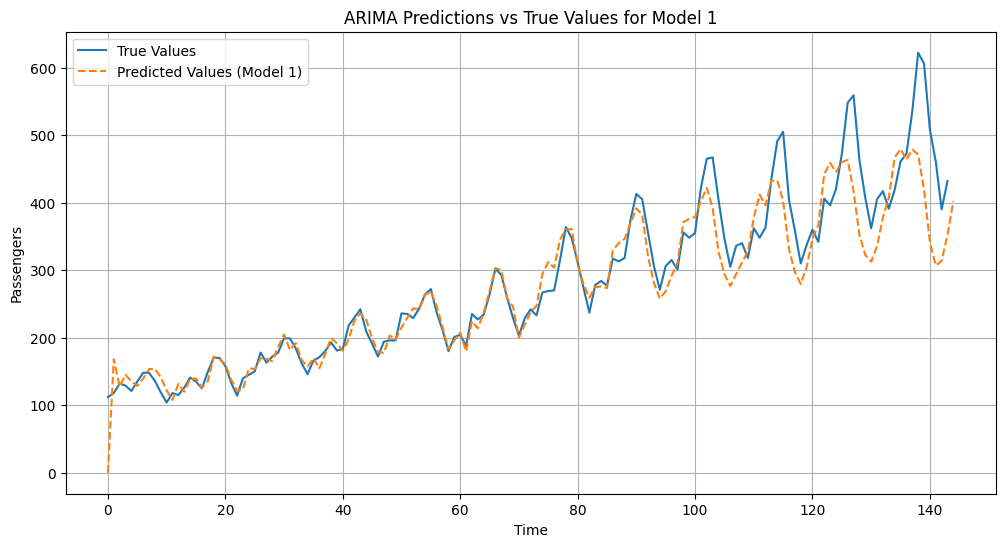

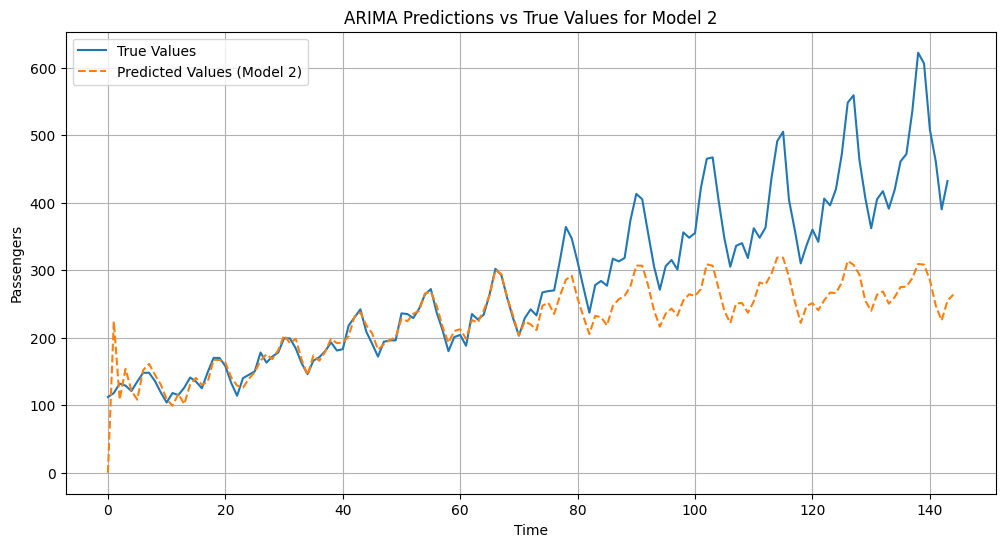

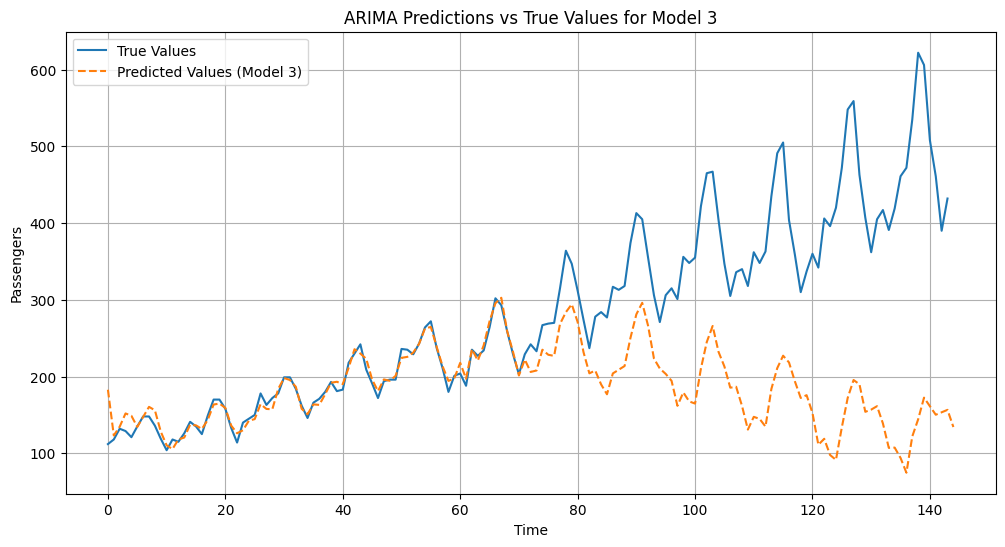

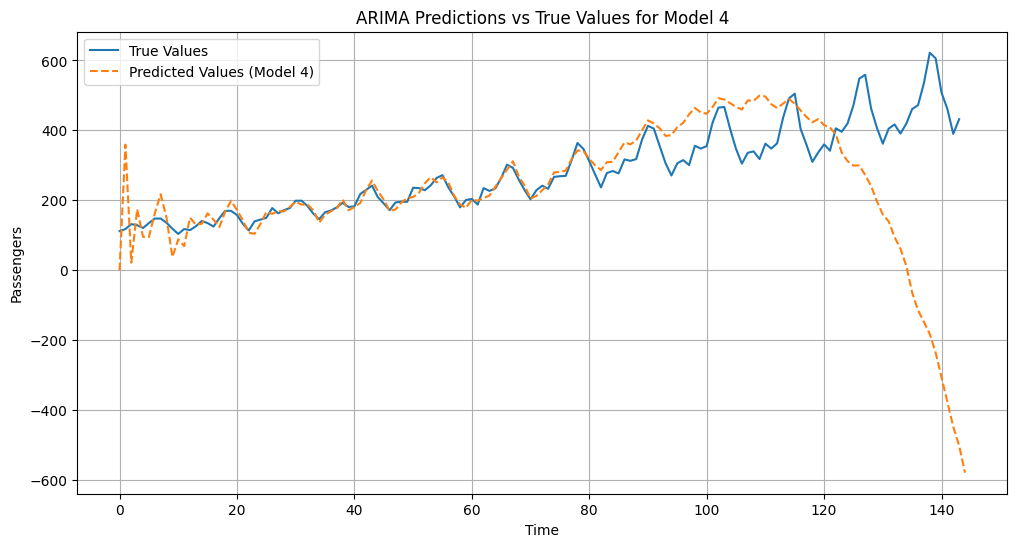

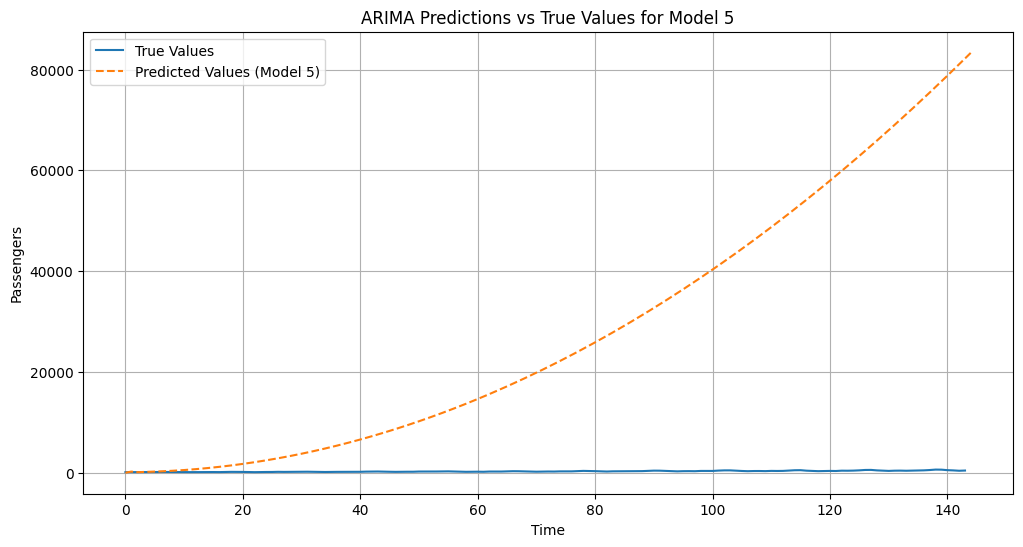

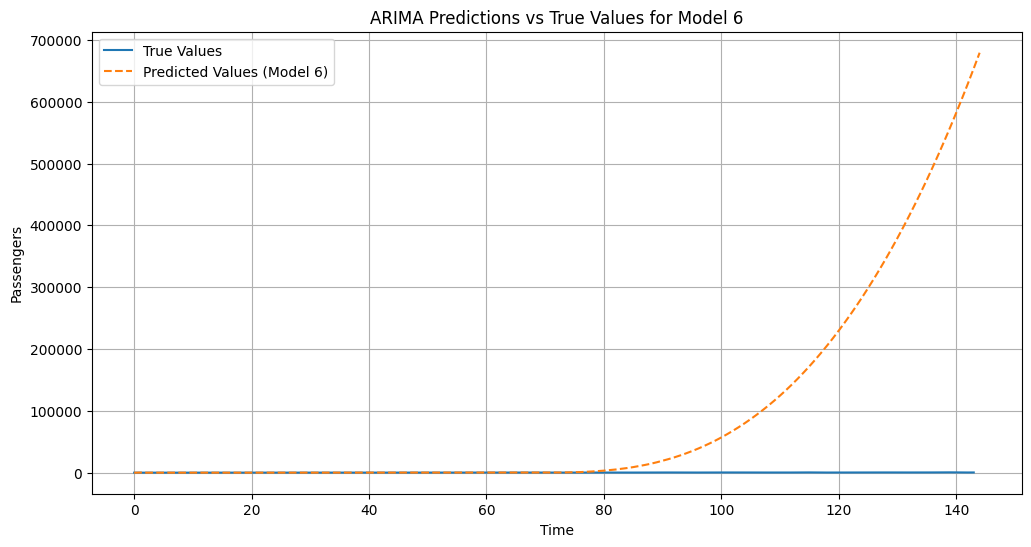

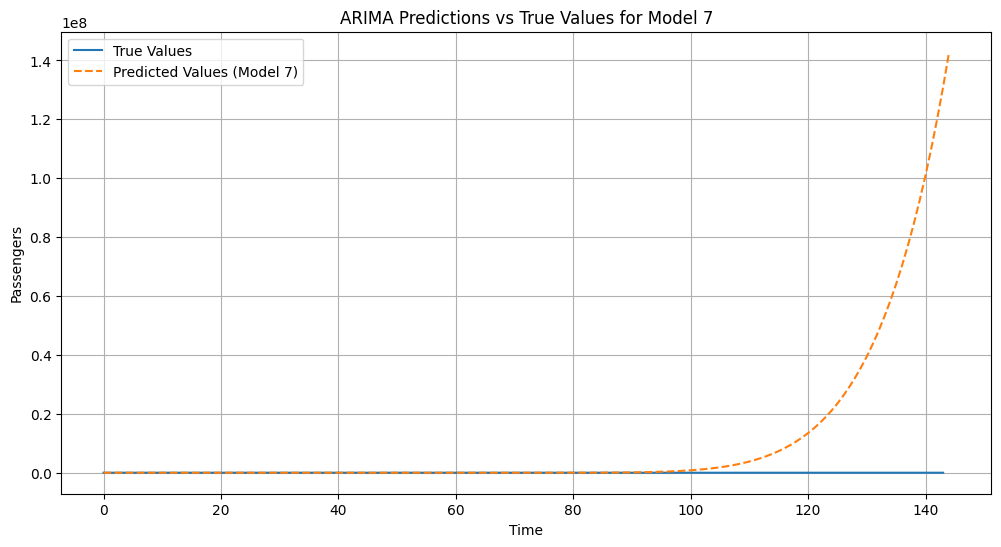

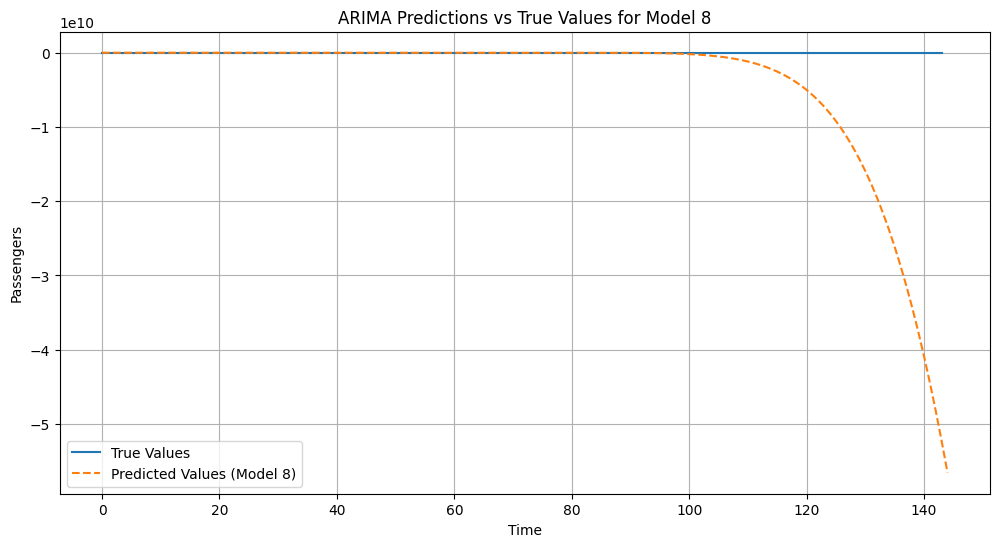

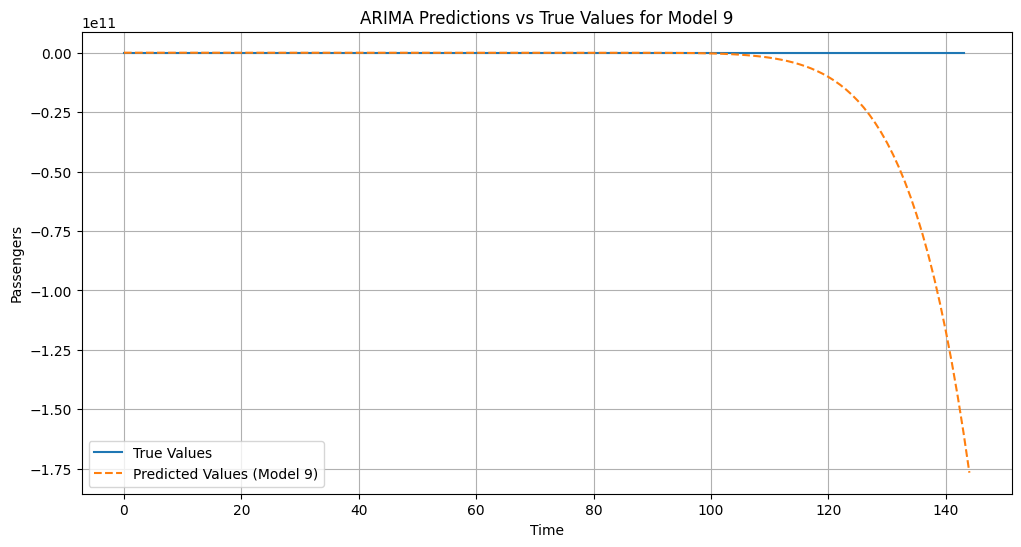

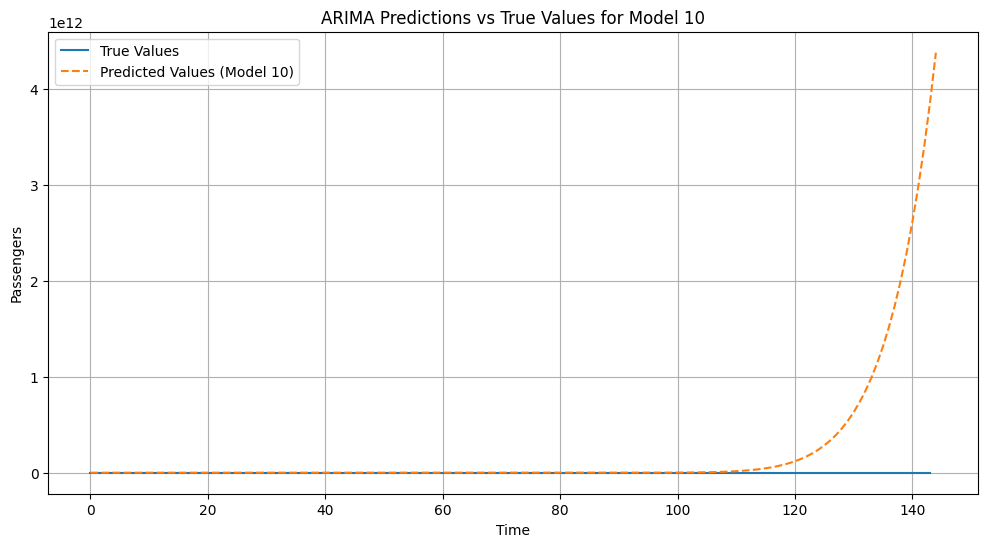

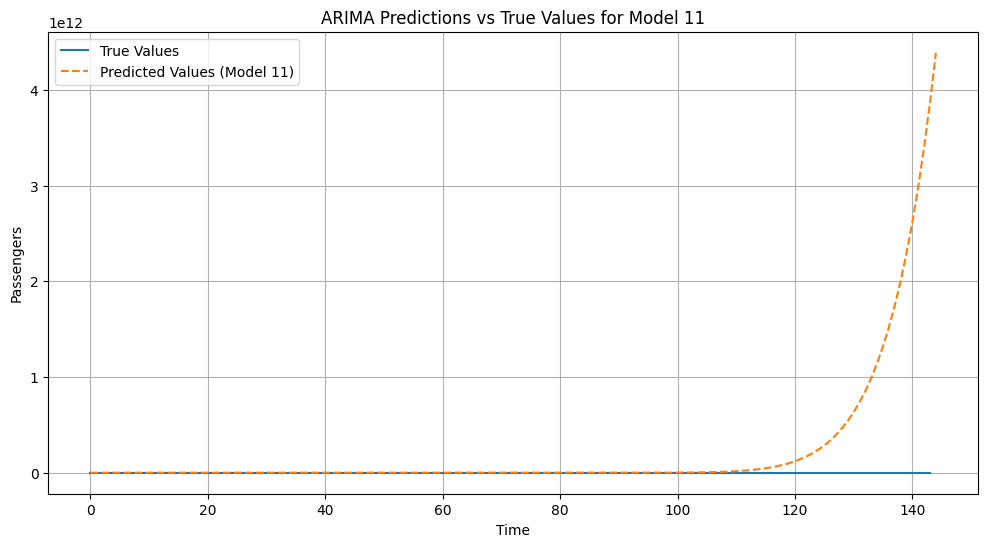

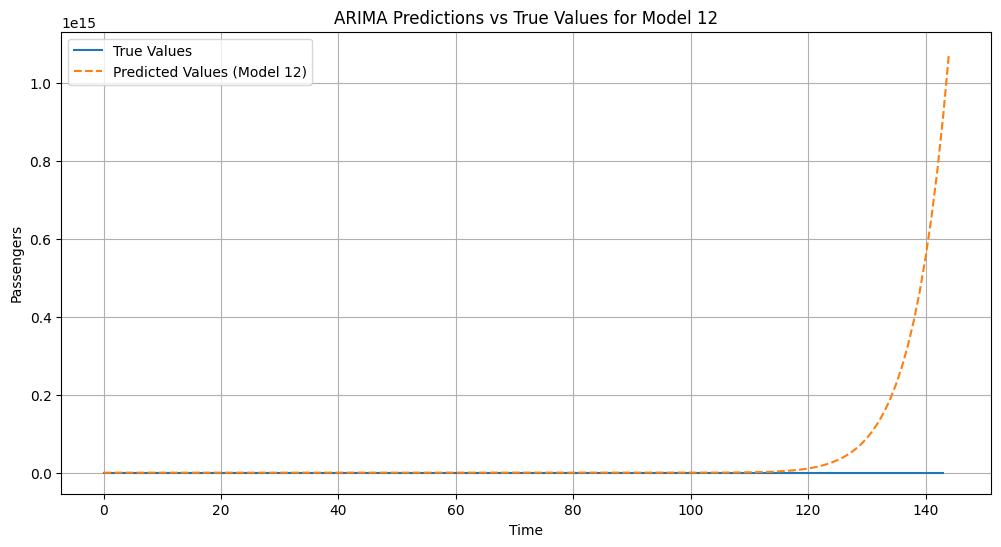

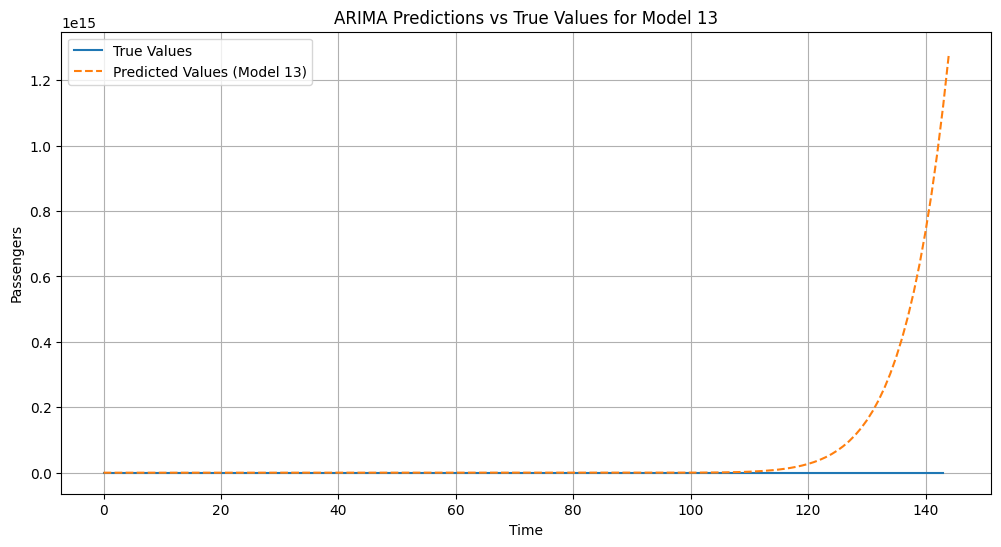

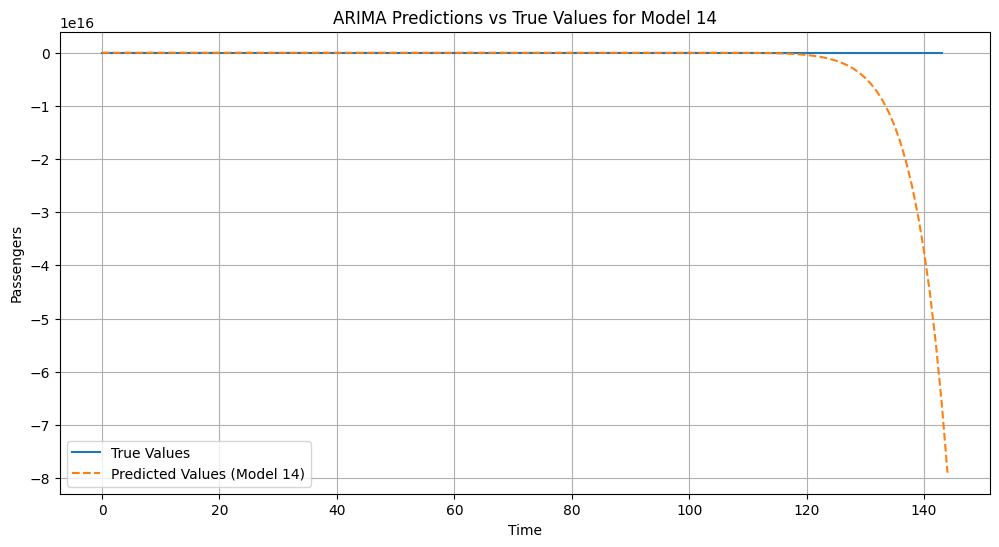

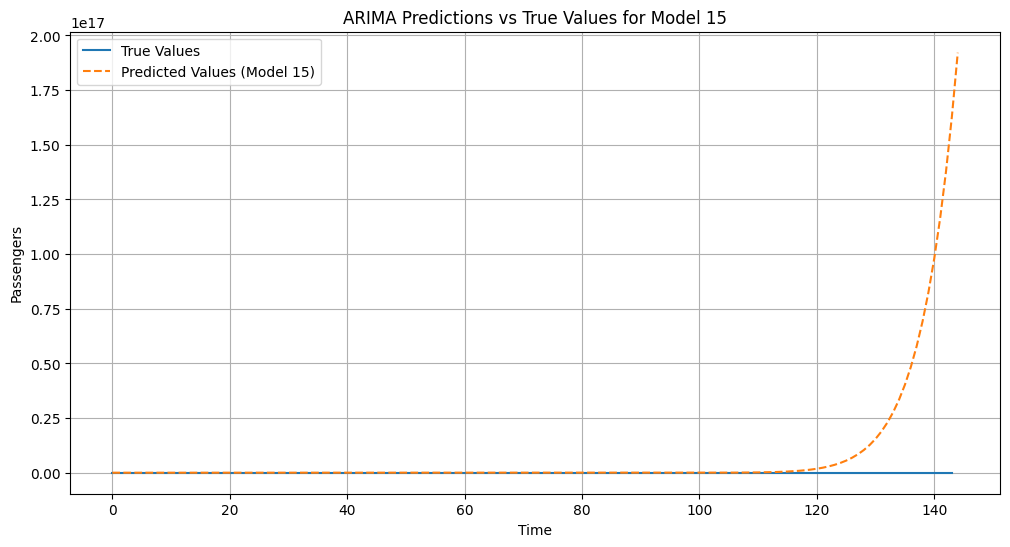

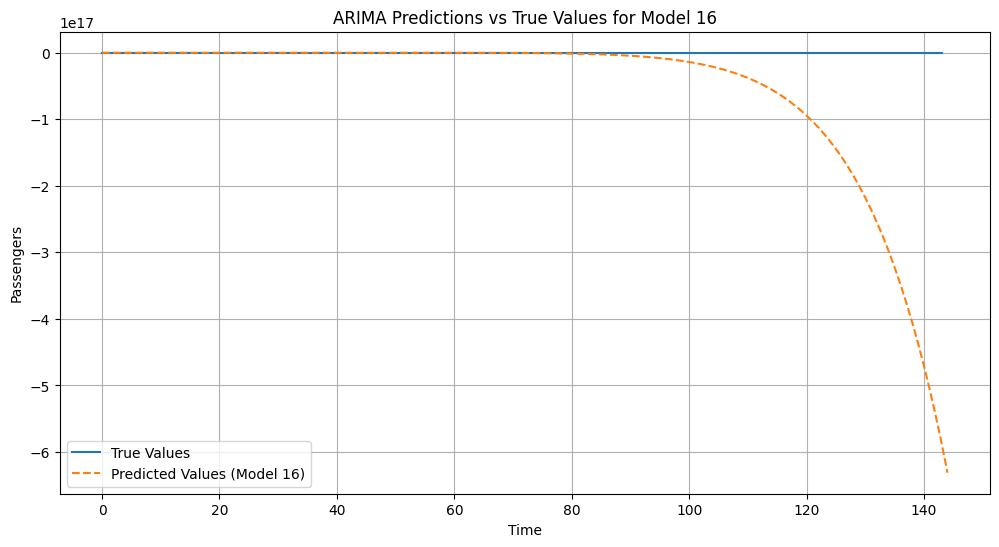

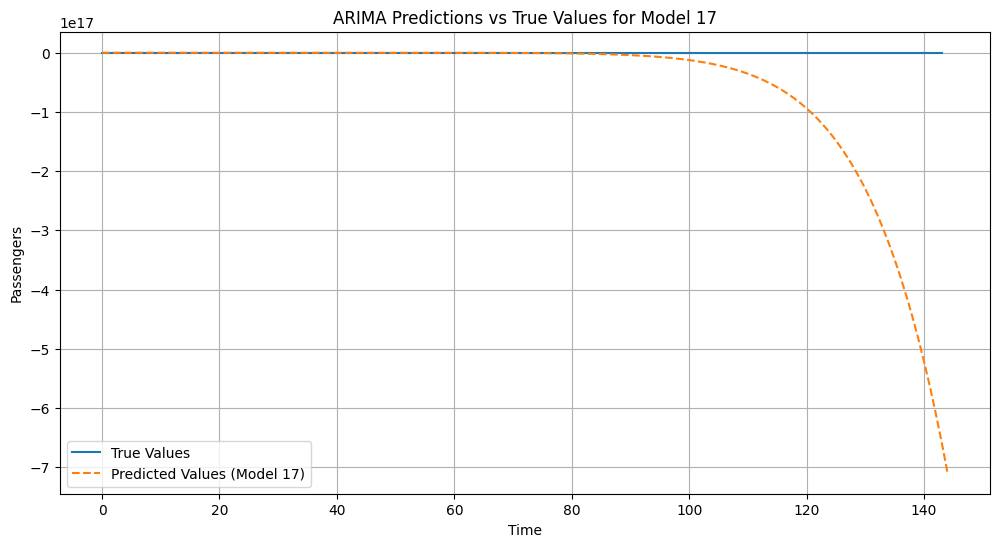

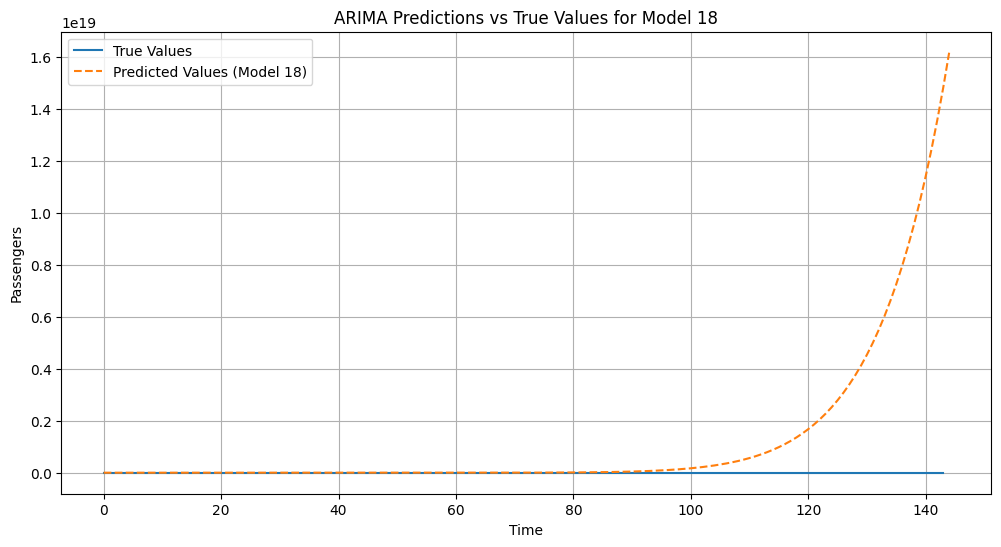

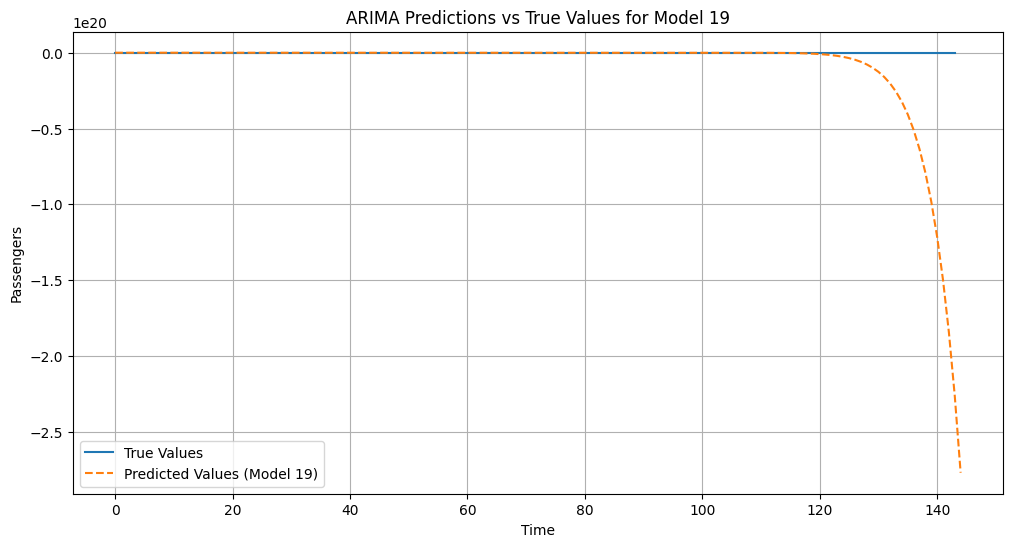

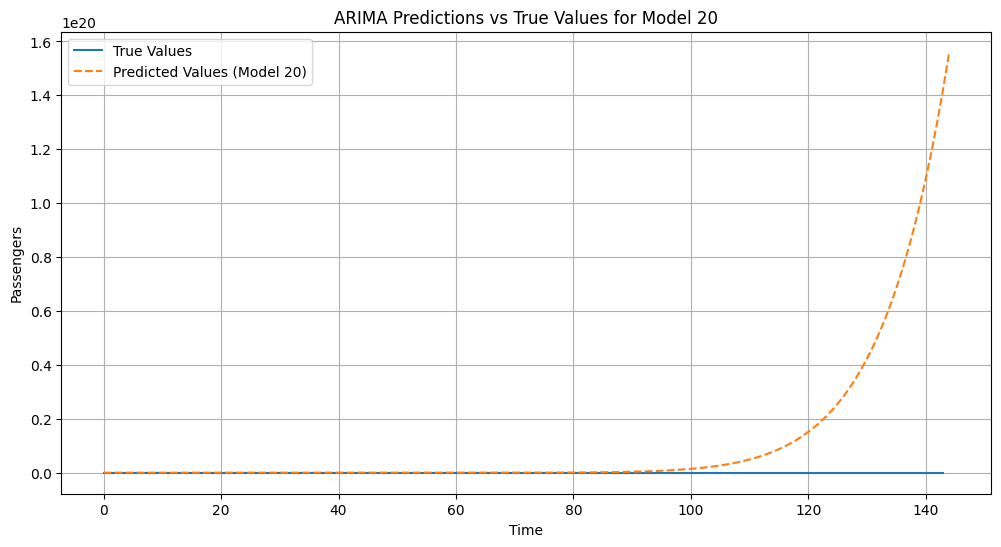

In [4]:
preds = wrapper.get_predictions(context="all")
true = wrapper.data.get_all(context = "ARIMA")


import matplotlib.pyplot as plt

for i, pred in enumerate(preds):
    plt.figure(figsize=(12, 6))
    plt.plot(true, label="True Values")
    plt.plot(pred, label=f"Predicted Values (Model {i+1})", linestyle='--')
    plt.title(f'ARIMA Predictions vs True Values for Model {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

preds = wrapper.get_predictions(context="all")
true = wrapper.data.get_all(context = "ARIMA")
import matplotlib.pyplot as plt

for i, pred in enumerate(preds):
    plt.figure(figsize=(12, 6))
    plt.plot(true, label="True Values")
    plt.plot(pred, label=f"Predicted Values (Model {i+1})", linestyle='--')
    plt.title(f'ARIMA Predictions vs True Values for Model {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

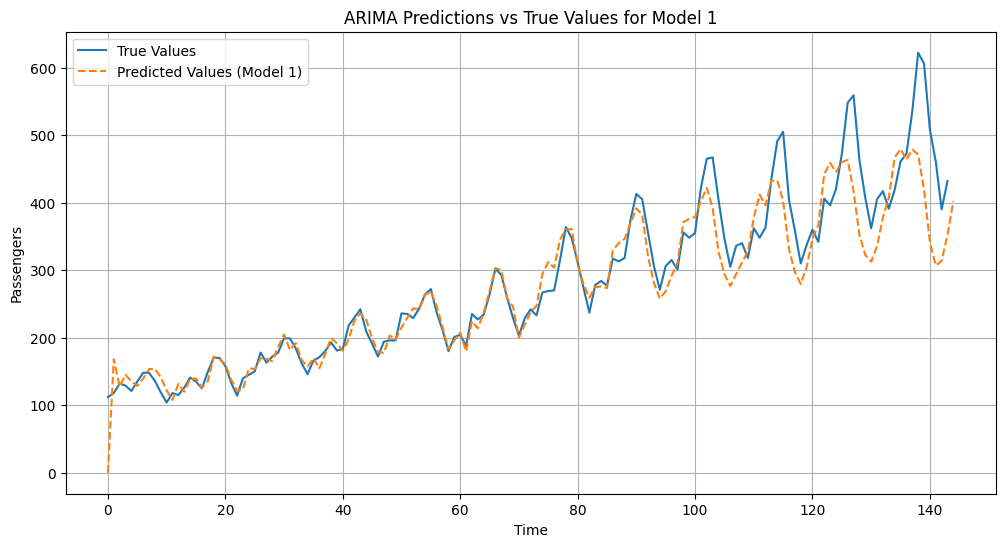

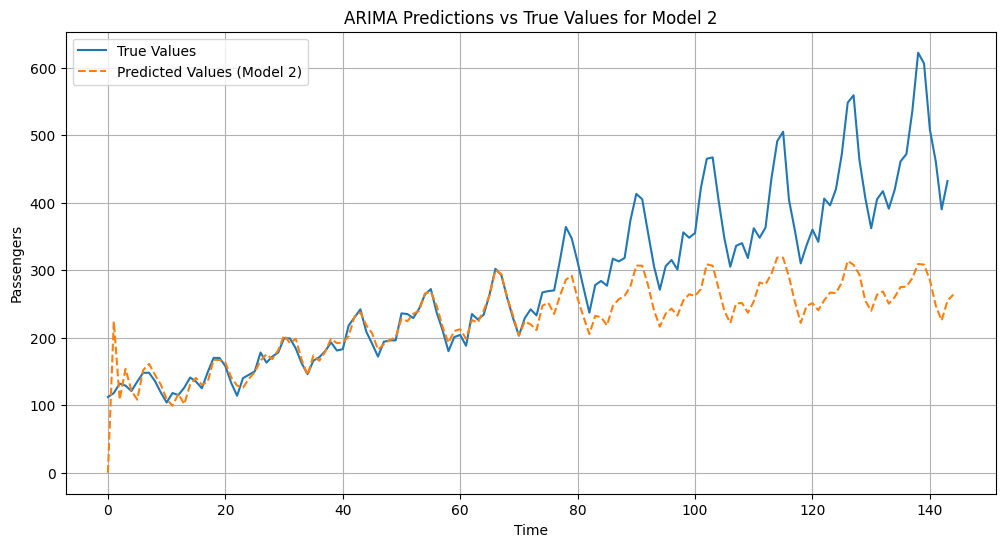

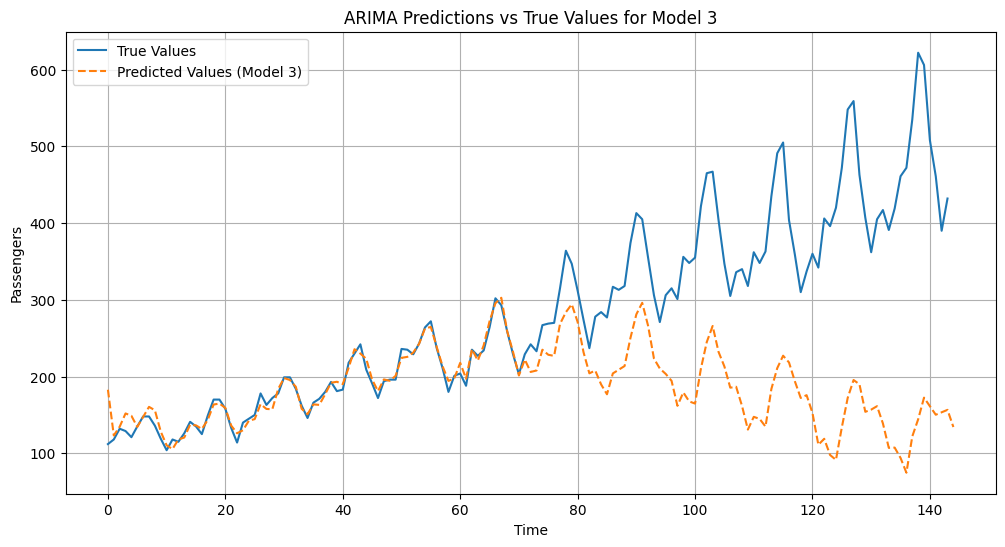

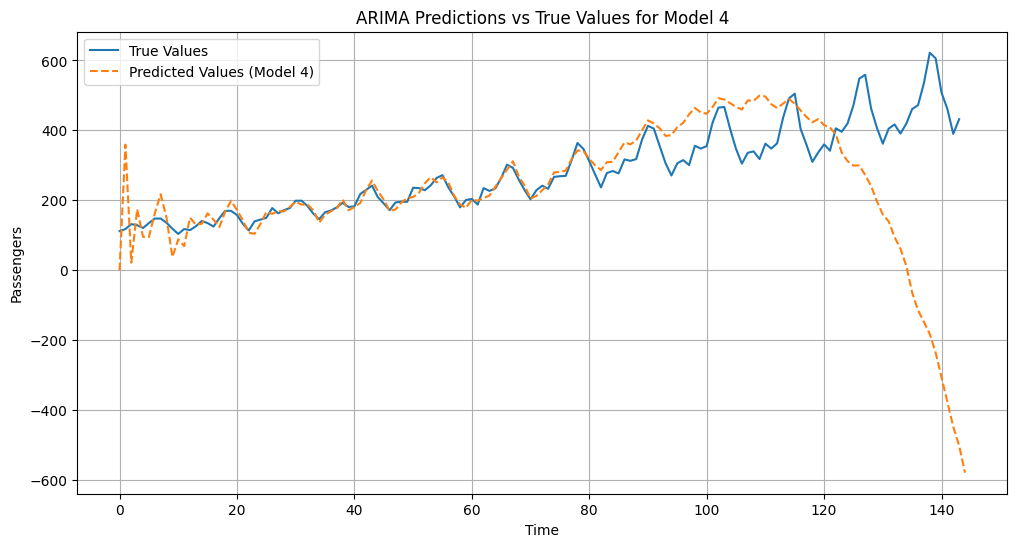

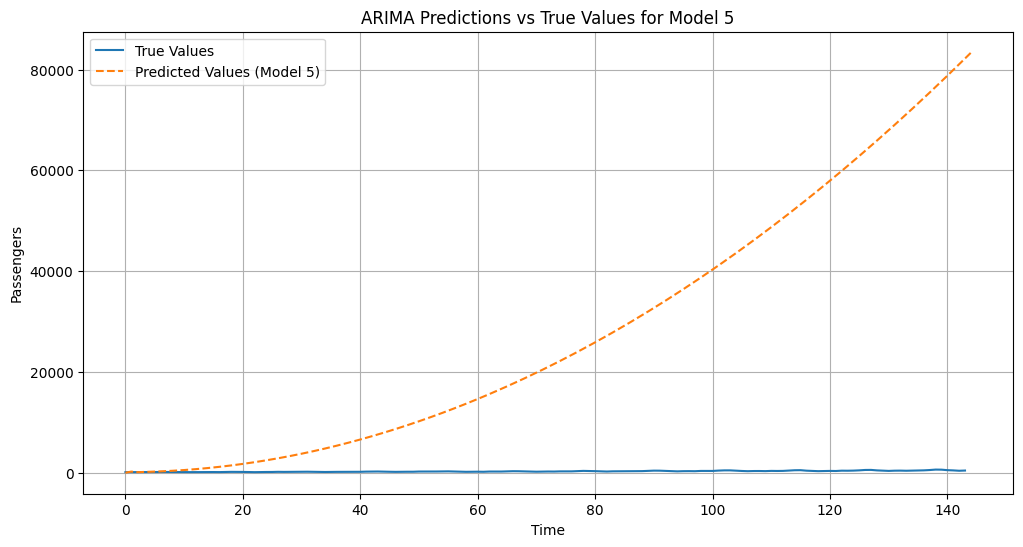

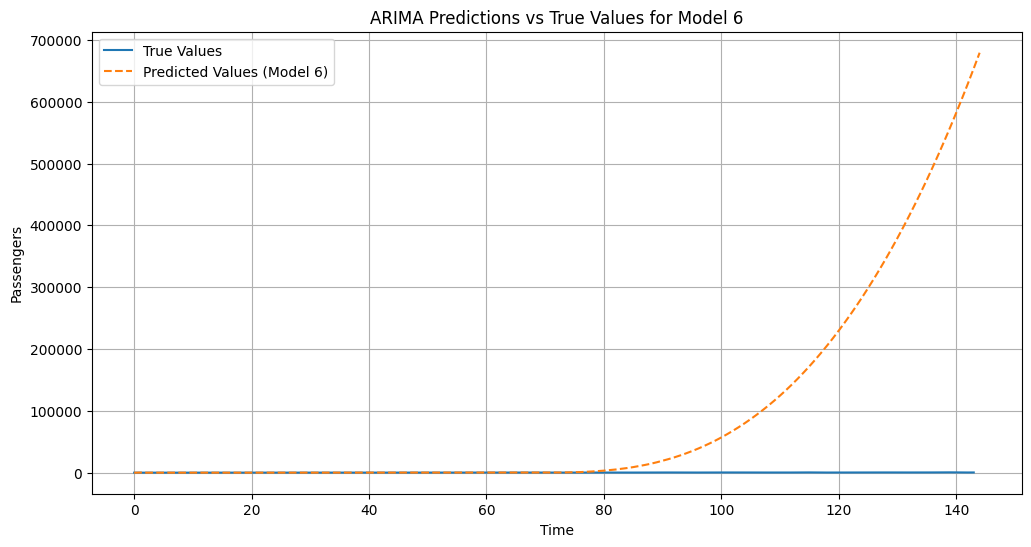

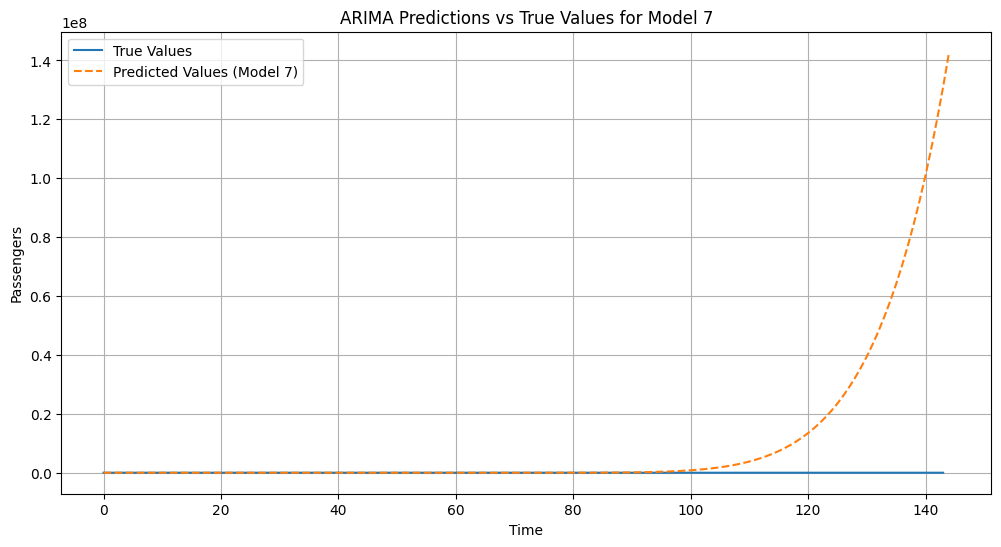

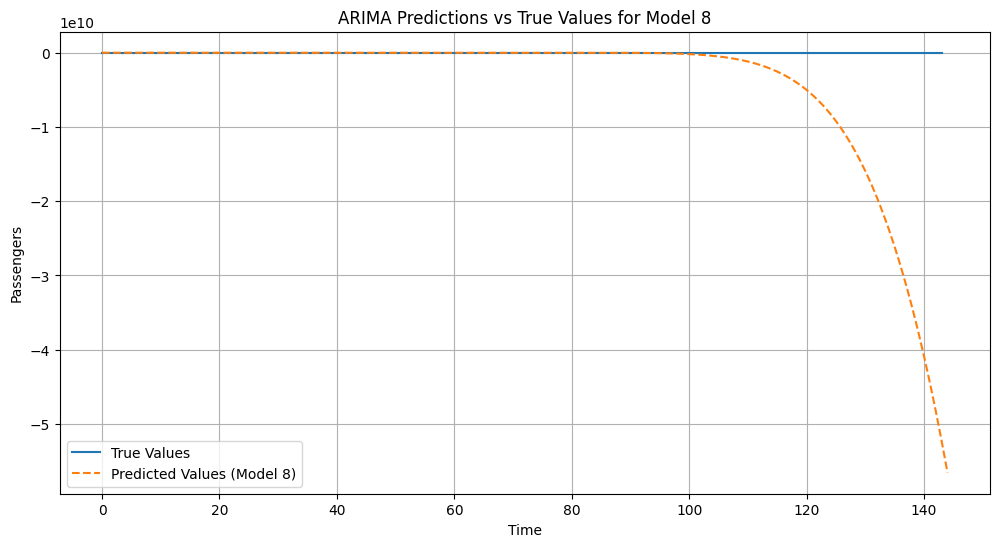

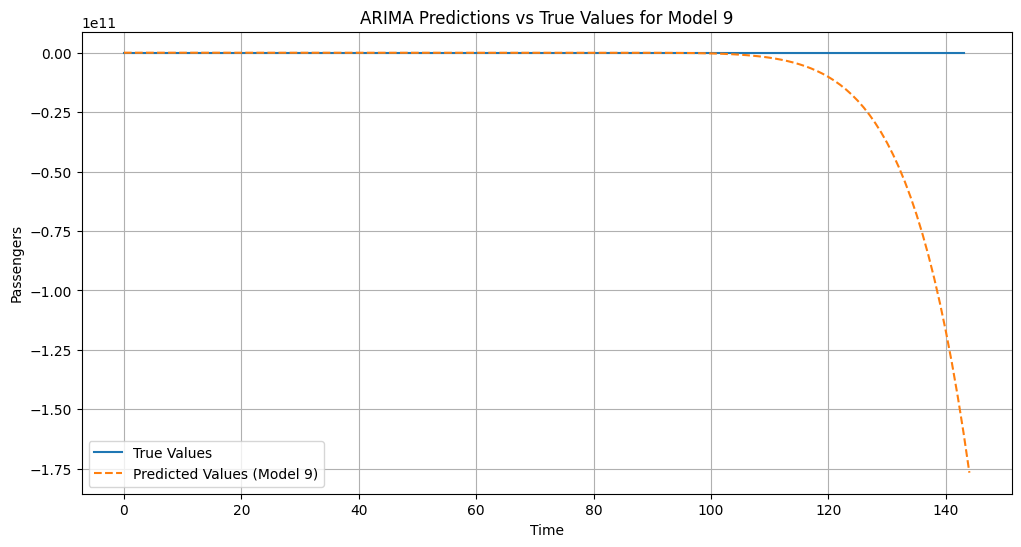

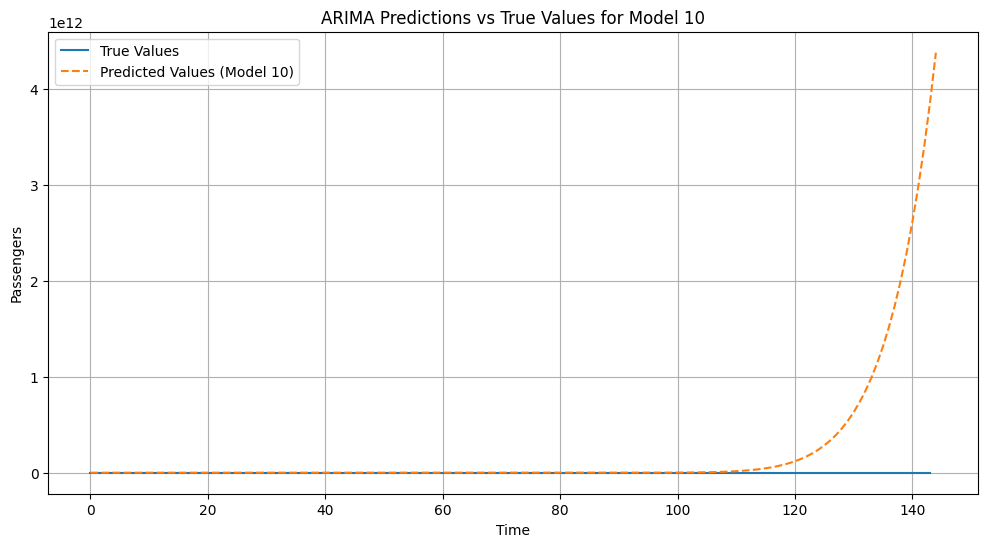

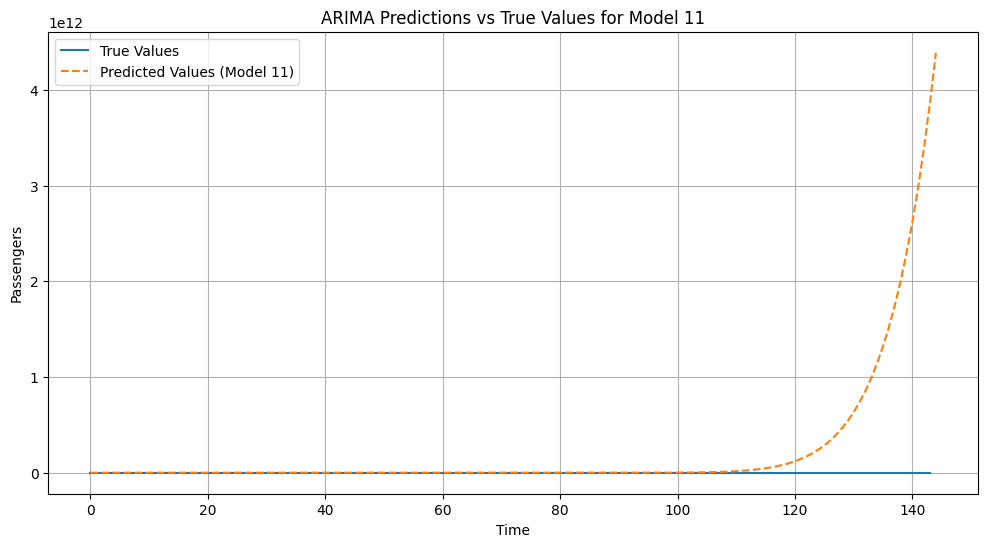

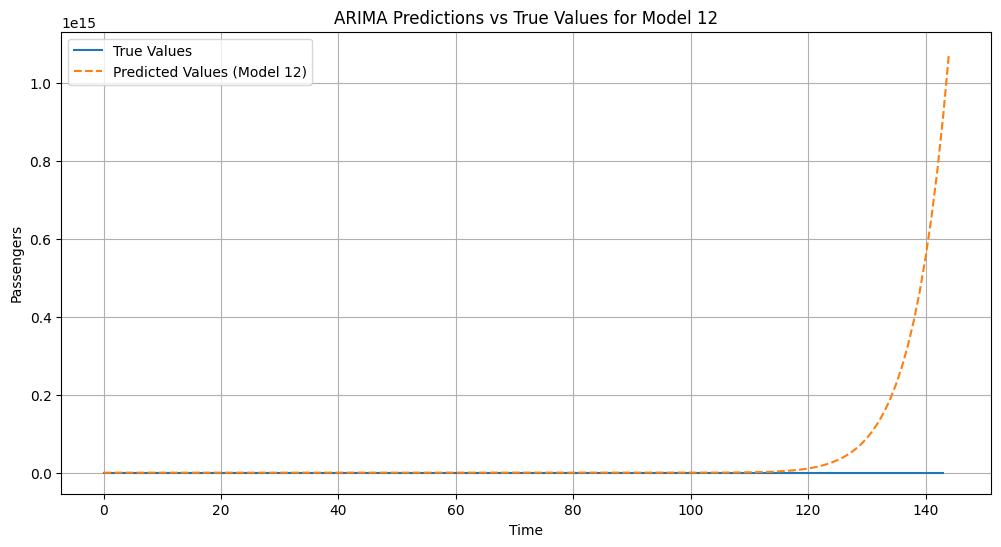

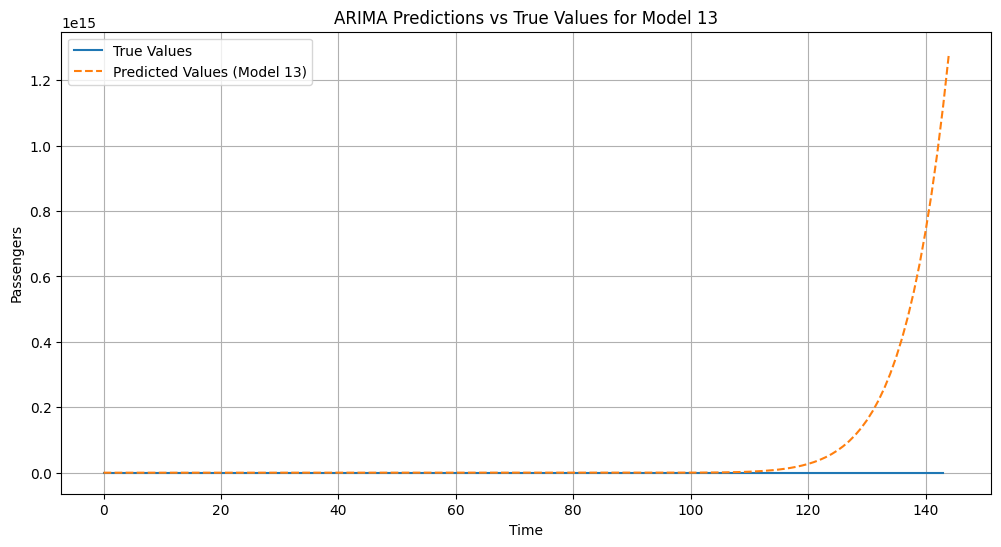

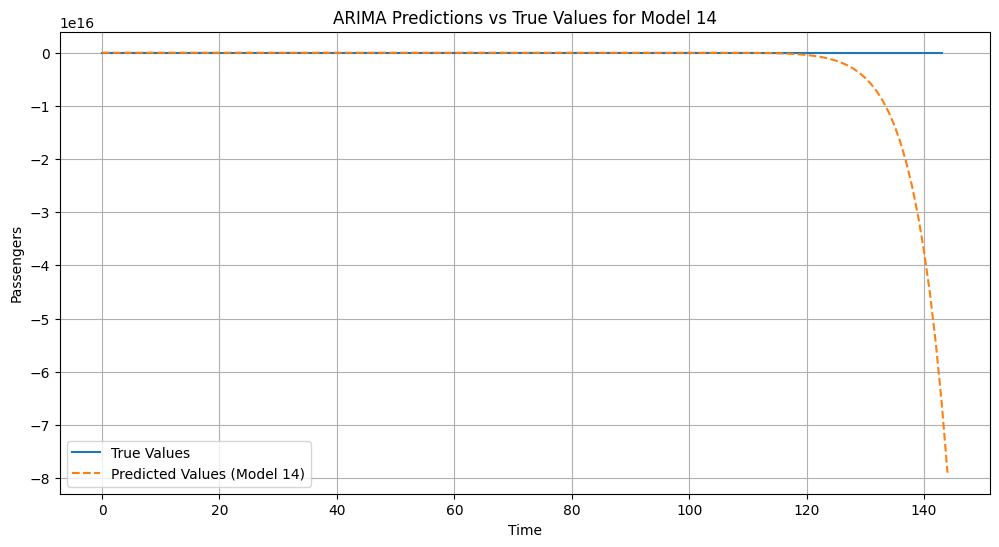

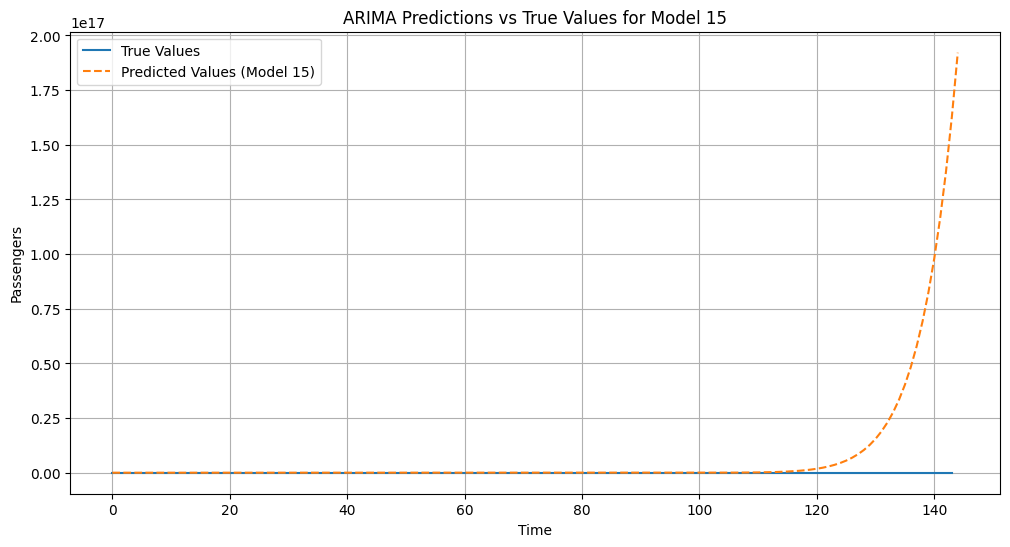

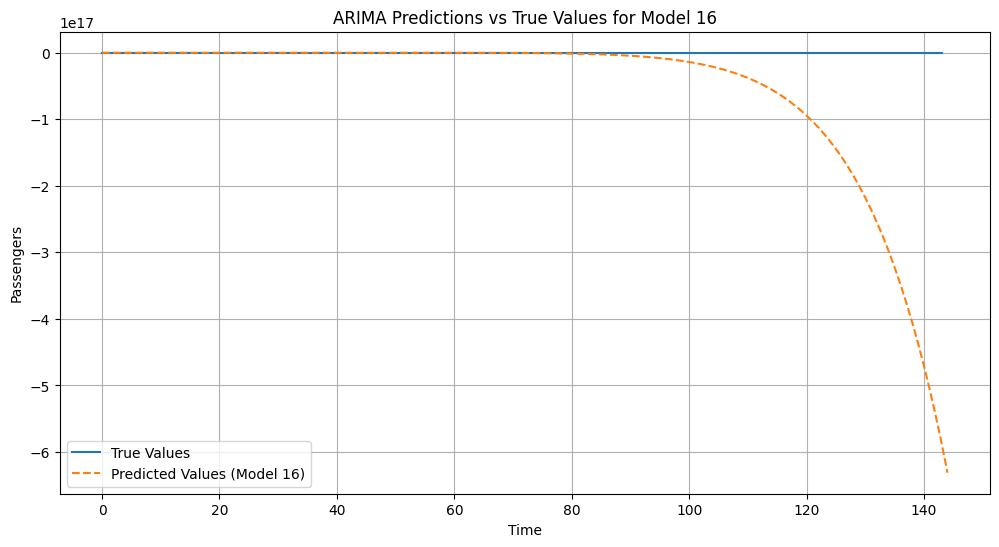

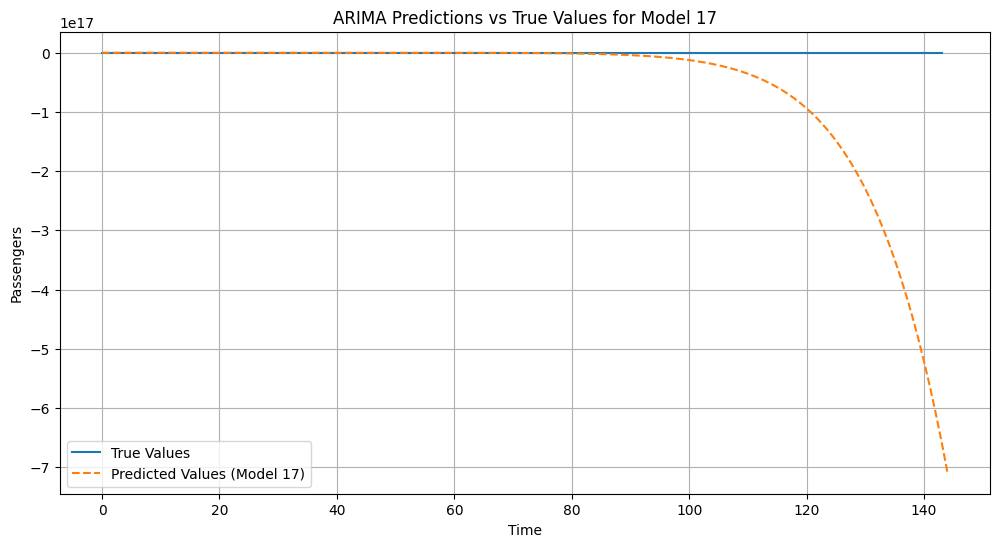

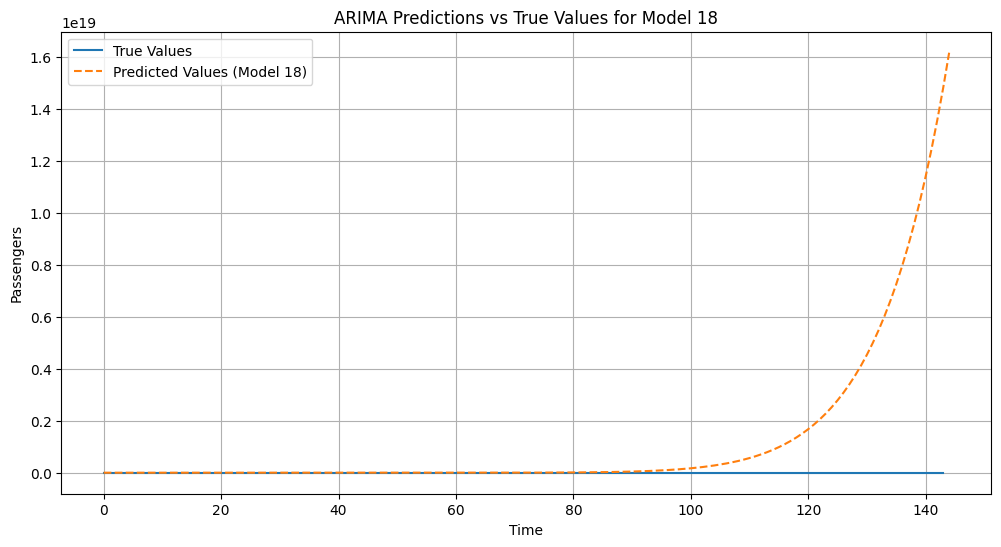

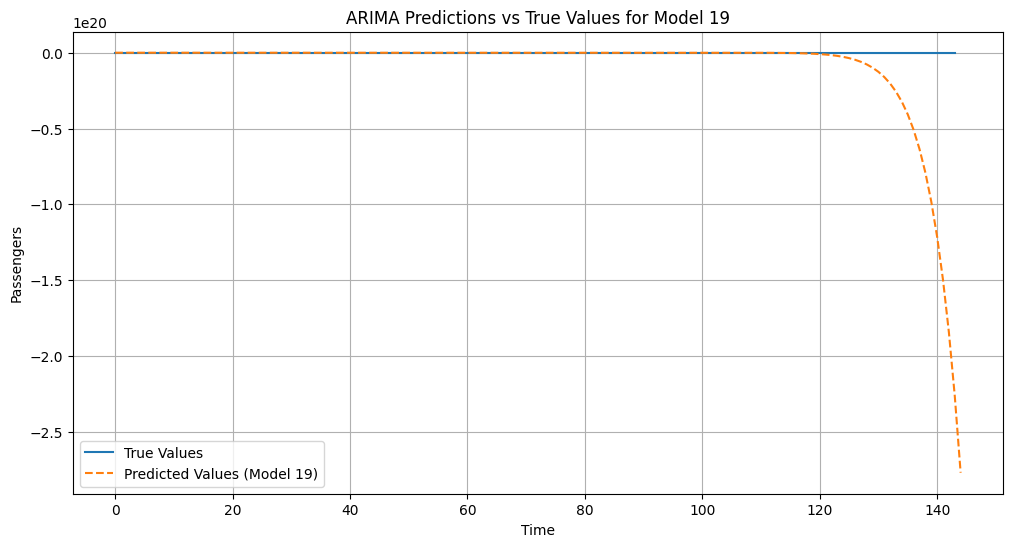

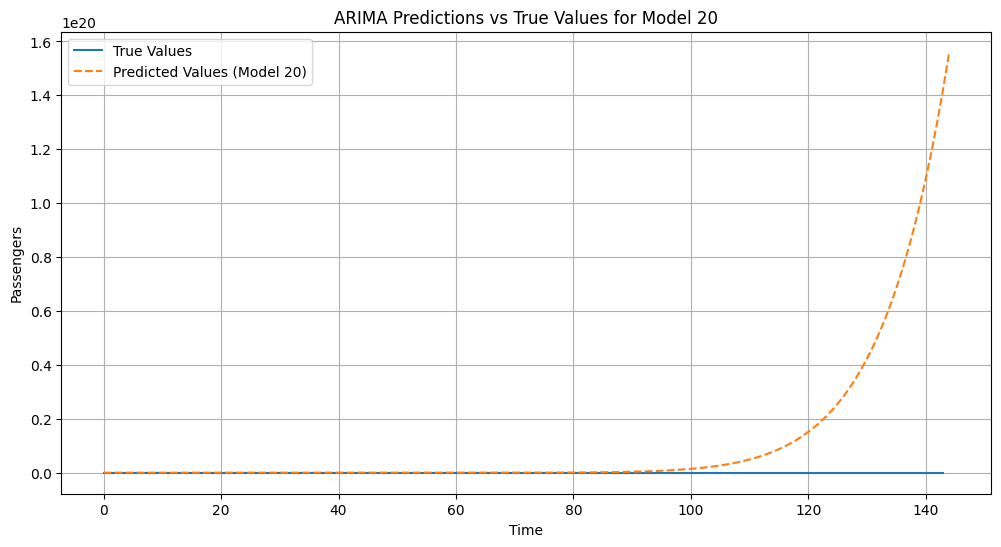

In [3]:
wrapper.gan_improve_functions(2, 20)
preds = wrapper.get_predictions(context="all")
true = wrapper.data.get_all(context = "ARIMA")

import matplotlib.pyplot as plt

for i, pred in enumerate(preds):
    plt.figure(figsize=(12, 6))
    plt.plot(true, label="True Values")
    plt.plot(pred, label=f"Predicted Values (Model {i+1})", linestyle='--')
    plt.title(f'ARIMA Predictions vs True Values for Model {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()